In [1]:
import sys
import numpy as np
from numpy import genfromtxt
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy import stats
from ipfx import feature_extractor
from ipfx import subthresh_features as subt
from ipfx import feature_vectors as fv
from ipfx.sweep import Sweep
from sklearn.preprocessing import minmax_scale
from pyAPisolation.loadABF import loadABF
import sklearn.preprocessing
import pyabf
import logging
import glob
method='trf'

In [2]:
import autograd.numpy as np
from autograd import grad



In [3]:

def exp_grow(t, a, b, alpha):
    return a - b * np.exp(-alpha * t)

def exp_grow_2p(t, a, b1, alphaFast, b2, alphaSlow):
    return a - b1 * np.exp(-alphaFast * t) - b2*np.exp(-alphaSlow*t) 

def exp_grow_clampfit(t, a, b1, alphaFast, b2, alphaSlow):
    return b1 * np.exp(-alphaFast * t) + b2*np.exp(-alphaSlow*t) 

In [4]:


f1 = grad(exp_grow_2p)  # 1st derivative of f
f2 = grad(f1) # 2nd derivative of f

def curvature(x, a, b1, alphaFast, b2, alphaSlow):
        return np.abs(f2(x, a, b1, alphaFast, b2, alphaSlow))*(1 + f1(x, a, b1, alphaFast, b2, alphaSlow)**2)**-1.5
    
    
def curvature_real(dy, ddy):
        return abs(dy)*(1 + ddy**2)**-1.5
    
def curvature_splines(x, y=None, error=0.1, smoothing=None):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std), s=smoothing)
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std), s=smoothing)

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature
    

def derivative(x,y):
    return np.diff(y)/np.diff(x)


def curve_detrend(x,y, curve2):
    test = curvature_splines(x, signal.savgol_filter(y, 51, 1), error=1, smoothing=25)
    cy = np.array([curvature(xi, *curve2) for xi in x])
    #detrend using first and last point
    lin_res = stats.linregress([x[0], x[-1]], [cy[0], cy[-1]])
    trend = x*lin_res.slope + lin_res.intercept
    #plt.plot(x,trend)
    detrended_data = cy - trend
    return detrended_data

In [5]:
def exp_growth_factor(dataT,dataV,dataI, end_index=300):
    #try:
        
        diff_I = np.diff(dataI)
        upwardinfl = np.argmax(diff_I)

        #Compute out -50 ms from threshold
        dt = dataT[1] - dataT[0]
        offset = 0.01/ dt 

        end_index = int(end_index - offset)


        
        upperC = np.amax(dataV[upwardinfl:end_index])
        lowerC  = np.amin(dataV[upwardinfl:end_index])
        diffC = np.abs(lowerC - upperC)
        t1 = dataT[upwardinfl:end_index] - dataT[upwardinfl]
        curve = curve_fit(exp_grow, t1, dataV[upwardinfl:end_index], maxfev=50000, bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))[0]
        curve = np.hstack((curve, np.full(2,1)))
        curve2 = curve_fit(exp_grow_2p, t1, dataV[upwardinfl:end_index], maxfev=50000,method='trf', p0=curve, bounds=([upperC-5,  0, 10,  0,  -np.inf], [upperC+5, diffC, np.inf, diffC,np.inf]), xtol=None, gtol=None, ftol=1e-12, jac='3-point')[0]
        tau = curve[2]
        tau1 = 1/curve2[2]
        tau2 = 1/curve2[4]
        tau_idx = [2, 4]
        fast = tau_idx[np.argmin([tau1, tau2])]
        slow = tau_idx[np.argmax([tau1, tau2])]
        
        curve_out = [curve2[0], curve2[fast-1], curve2[fast], curve2[slow-1], curve2[slow]]


        #plt.subplot(1,2,1)
        plt.plot(t1, dataV[upwardinfl:end_index], c='k', alpha=0.5)
        plt.plot(t1, exp_grow_2p(t1, *curve2), label=f'2 phase fit', c='r', alpha=0.5)
        plt.plot(t1, exp_grow(t1, *curve_out[:3]), label=f'Fast phase', c='g', alpha=0.5)
        plt.plot(t1, exp_grow(t1, curve_out[0], *curve_out[3:]), label=f'slow phase', c='b', alpha=0.5)
        plt.title(f" CELL will tau1 {1/curve2[fast]} and tau2 {1/curve2[slow]}")
        #plt.subplot(1,2,2)
        plt.legend()
        #plt.twinx()
        #plt.subplot(1,2,2)
        dy = curve_detrend(t1, dataV[upwardinfl:end_index], curve2)
         #signal.savgol_filter(nt1p.diff(dataV[upwardinfl:end_index])/np.diff(t1), 71, 2, mode='mirror')
        #plt.plot(t1,dy)
        
        curve_out = [curve2[0], curve2[fast-1], 1/curve2[fast], curve2[slow-1], 1/curve2[slow]]
        return curve_out, np.amax(dy)
    #except:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]

In [6]:
files = glob.glob('C:\\Users\\SMest\\Documents\\clustering-data\\\All IC1s\\*.abf', recursive=True)

In [8]:
cell_type_df = pd.read_csv("/media/smestern/Expansion/PVN_MARM_PROJECT/dataframe/main_sheet_filtered2.csv")
print(cell_type_df.head)
file_names = cell_type_df['filename'].to_numpy()
cell_type_label = cell_type_df['cell_label'].to_numpy()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\SMest\\Documents\\clustering-data\\MARM_PVN_IC1\\spike_count_sort_out.csv'

In [ ]:
curves = []
label = []
ids = []
max_curve = []
for i, f in enumerate(files[-20:]):
        print(i)
    #try:
        base = os.path.basename(f)
        base = base.split(".")[0]
        if base in file_names:
            x, y, c = loadABF(f)
            
            temp_curves =[]
            #plt.clf()
            iterd = 0
            for sweepX, sweepY, sweepC in zip(x,y,c):
                spikext = feature_extractor.SpikeFeatureExtractor(filter=0, end=1.25)
                res = spikext.process(sweepX, sweepY, sweepC)
                if res.empty==False and iterd < 3:
                    iterd += 1
                    spike_time = res['threshold_index'].to_numpy()[0]
                    #plt.figure(num=2)
                    curve, max_dy = exp_growth_factor(sweepX, sweepY, sweepC, spike_time)
                    max_curve.append(max_dy)
                    temp_curves.append(curve)
            temp_curves = np.vstack(temp_curves)
            div = np.ravel((temp_curves[:,2]) / (temp_curves[:,4])).reshape(-1,1)
            
            sum_height= (temp_curves[:,1] + temp_curves[:,3])
            ratio = (temp_curves[:,2] / (temp_curves[:,1] / sum_height)) / (temp_curves[:,4] / (temp_curves[:,3] / sum_height))
            ratio = np.ravel(ratio).reshape(-1,1)
            temp_curves = np.hstack([temp_curves, div, ratio])
            print(temp_curves)
            meanC = np.nanmean(temp_curves, axis=0)
            print(meanC.shape)
            curves.append(meanC)
            label_idx = np.argwhere(file_names==base)
            

            label.append(cell_type_label[label_idx])
            
            ids.append(base)
            plt.savefig(f+".png")
            plt.show()
            
            plt.close()
    #except:
        #print("fail")
curves = np.vstack(curves)

0


ValueError: `x0` is infeasible.

In [ ]:
#lab = sklearn.preprocessing.LabelEncoder()
#int_lab = lab.fit_transform(label)
print(curves)
label = np.ravel(label).reshape(-1,1)
div = np.ravel((curves[:,2]) / (curves[:,4])).reshape(-1,1)
print(div)
sum_height= (curves[:,1] + curves[:,3])
ratio = (curves[:,2] / (curves[:,1]/sum_height)) / (curves[:,4] / (curves[:,3]/sum_height))
ratio = np.ravel(ratio).reshape(-1,1)
curves_out = np.hstack([curves, div, ratio, label])
np.savetxt('curves.csv', curves_out, fmt='%.8f', delimiter=',')
np.savetxt('curves_id.csv', ids, fmt='%s', delimiter=',')
print(curves)

[[-43.3712   7.3192   0.0026 ...   0.0204   0.1609   0.5899]
 [-46.473   41.042    0.0307 ...   0.0307   1.       0.9813]
 [-49.5654  17.7859   0.0225 ...   0.0407   0.728    1.0402]
 ...
 [-40.3186  14.5123   0.0108 ...   0.0183   0.7416   1.2063]
 [-29.078   43.5267   0.0405 ...   0.0405   1.       0.9205]
 [-45.5473  22.652    0.0262 ...   0.0501   0.7153   0.7846]]
[[0.1264]
 [1.    ]
 [0.5519]
 ...
 [0.5907]
 [1.    ]
 [0.522 ]]
[[-43.3712   7.3192   0.0026 ...   0.0204   0.1609   0.5899]
 [-46.473   41.042    0.0307 ...   0.0307   1.       0.9813]
 [-49.5654  17.7859   0.0225 ...   0.0407   0.728    1.0402]
 ...
 [-40.3186  14.5123   0.0108 ...   0.0183   0.7416   1.2063]
 [-29.078   43.5267   0.0405 ...   0.0405   1.       0.9205]
 [-45.5473  22.652    0.0262 ...   0.0501   0.7153   0.7846]]


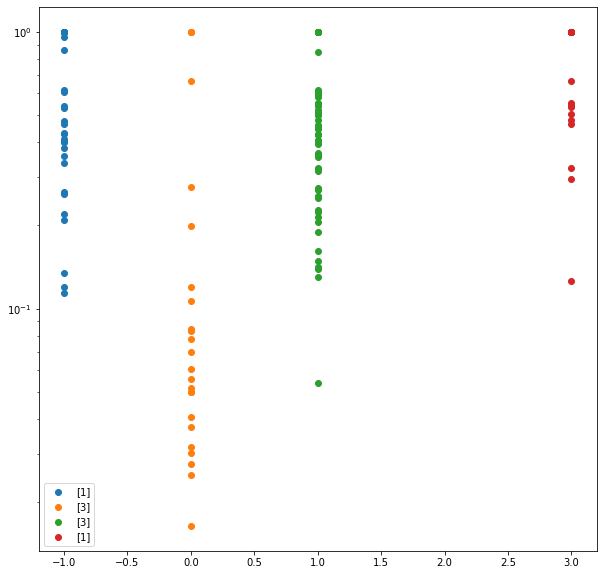

In [ ]:
means = []
plt.figure(figsize=(10,10))
plt.clf()
for x in np.unique(label).astype(np.int32):
    idx = np.argwhere(label[:,0]==x).astype(np.int32)
    mcur = curves[idx]
    plt.scatter(np.full(len(idx),  x),  (curves[idx,2]) / (curves[idx,4]), label=label[x])
    means.append(np.nanmean((curves[idx,2]) / (curves[idx,4])))
plt.legend()
plt.yscale('log')
#plt.ylim(0,1)

In [ ]:
print(means)

[0.6147261592891329, 0.2098075972627813, 0.5349679047293305, 0.7249502881765328]


In [ ]:
1=1
curves = []
label = []
ids = []
for i, f in enumerate(files[:38]):
    print(i)
    x, y, c = loadABF(f)
    d_name = os.path.dirname(f)
    base = os.path.basename(f)
    ids.append(base)
    label.append(d_name)
    dfs = []
    temp_curves
    plt.clf()
    for sweepX, sweepY, sweepC in zip(x,y,c):
        spikext = feature_extractor.SpikeFeatureExtractor(filter=0)
        res = spikext.process(sweepX, sweepY, sweepC)
        dfs.append(res)
        if res.empty==False:
            if len(non_empty_df) > 1:
                sweep_to_use = non_empty_df[1]
            else:
                sweep_to_use = non_empty_df[-1]
    non_empty_df = np.nonzero(np.invert([df.empty for df in dfs]))[0]
    
    
    try:
        spike_time = dfs[sweep_to_use]['threshold_index'].to_numpy()[0]
        curve = exp_growth_factor(x[sweep_to_use,:], y[sweep_to_use,:], c[sweep_to_use,:], spike_time)
        curves.append(curve)
    except:
        curves.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    plt.show()
print(non_empty_df)

SyntaxError: can't assign to literal (<ipython-input-12-3b77a170223a>, line 1)